In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite.data_processing import DataFrame
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr

In [2]:
from astropy.visualization import astropy_mpl_style
astropy_mpl_style['axes.grid'] = False
plt.style.use(astropy_mpl_style)

from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

In [3]:
# Normalization with sca
def stand_sca(data):
    new_data=(data-data.mean())/data.std()
    return new_data

In [16]:
#读入数据为dataframe格式，并做0均值1标准差处理
df_result = pd.read_excel(r'NE Atlantic-FAO.xlsx')
df_result = df_result.drop(columns=['year', 'region-FAO'])
df_result = stand_sca(df_result)
df_result.head()

,A.landing-sum,S.landing-sum,temp,sea_level
0,0.102225,-0.379096,-0.793805,-1.228866
1,0.381459,-0.128519,-0.460517,-1.187864
2,0.282705,0.284326,-0.944528,-1.150002
3,0.933118,-0.419939,0.525573,-1.132004
4,0.497239,0.392505,-0.991248,-1.100308


In [5]:
#生成切片
def Generate(dataframe, step, cliplen):
    
    #序列总长度
    Len = len(dataframe)
    #切片数量
    num = (Len - cliplen) // step + 1
    
    dfs = []
    
    for i in range(0, num):
        df = dataframe.loc[i * step : i * step + cliplen - 1]
        dfs.append(df)
        
    return dfs, num

In [17]:
all_clips, number = Generate(df_result, 6, 20)

In [7]:
#运行PCMCI
def Run_PCMCI(file, tau):
    
    # raw values from csv 
    dataset1 = file.to_numpy()

    # variable names
    var_names = [ r'$A.landing$', r'$S.landing$', r'$temp$', r'$sea_level$']

    # generate the dataframe
    dataframe_y = DataFrame({1: dataset1}, analysis_mode='single', var_names=var_names)
    
    # use Partial Correlation as the Conditional Independence test
    p = parcorr.ParCorr(significance='analytic')
    pcmci = PCMCI(
        dataframe=dataframe_y, 
        cond_ind_test=p,
        verbosity=1)
    
    results = pcmci.run_pcmci(tau_max=tau, pc_alpha=[0.01,0.05,0.1,0.2,0.3,0.4,0.5])
    mci_all = results['val_matrix'].round(2)
    print(mci_all)
    mci_var = []
    for i in range(len(mci_all)):
        mci_var.append(np.mean(np.abs(mci_all[i]), axis=1))
    mci_var = np.array(mci_var)
    print(mci_var)
    
    return mci_var

In [18]:
AT = []
ST = []
ASLR = []
SSLR = []

for i in range(0, number):
    matrix = Run_PCMCI(all_clips[i], 6)
    AT.append(matrix[0][2])
    ST.append(matrix[1][2])
    ASLR.append(matrix[0][3])
    SSLR.append(matrix[1][3])
    
import csv

content = zip(AT, ST, ASLR, SSLR)

with open('NE_interactions.csv', "w") as s:
    w = csv.writer(s)
    for row in content:
        w.writerow(row)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 6
pc_alpha = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 4 link(s):
    [pc_alpha = 0.4]
        ($sea_level$ -3): max_pval = 0.12038, min_val =  0.642
        ($temp$ -2): max_pval = 0.25494, min_val = -0.630
        ($A.landing$ -6): max_pval = 0.36542, min_val = -0.523
        ($temp$ -4): max_pval = 0.38479, min_val =  0.506

    Variable $S.landing$ has 4 link(s):
    [pc_alpha = 0.3]
        ($sea_level$ -2): max_pval = 0.06163, min_val =  0.860
        ($sea_level$ -1): max_pval = 0.11416, min_val = -0.710
        ($sea_level$ -4): max_pval = 0.23769, min_val = -0.647
        ($sea_level$ -6): max_pval = 0.25377, min_val =  0.499

    Variable $temp$ has 3 link(s):
    [pc_alpha = 0.2]
        ($temp$ -6): max_pval = 0.07703, min_val = -0.705
   


## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 3 link(s):
    [pc_alpha = 0.5]
        ($S.landing$ -3): max_pval = 0.21123, min_val =  0.597
        ($A.landing$ -2): max_pval = 0.33178, min_val = -0.433
        ($A.landing$ -5): max_pval = 0.43368, min_val = -0.356

    Variable $S.landing$ has 5 link(s):
    [pc_alpha = 0.5]
        ($sea_level$ -2): max_pval = 0.11922, min_val = -0.643
        ($A.landing$ -6): max_pval = 0.41355, min_val = -0.480
        ($sea_level$ -4): max_pval = 0.44540, min_val = -0.389
        ($A.landing$ -4): max_pval = 0.47781, min_val =  0.295
        ($A.landing$ -3): max_pval = 0.48375, min_val = -0.291

    Variable $temp$ has 3 link(s):
    [pc_alpha = 0.5]
        ($temp$ -4): max_pval = 0.13214, min_val = -0.765
        ($temp$ -3): max_pval = 0.18539, min_val = -0.566
        ($S.landing$ -6): max_pval = 0.40252, min_val = -0.345

    Variable $sea_level$ has 6 link(s):
    [pc_alpha = 0.5]
        ($sea_level$ -1): max_pva


## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 5 link(s):
    [pc_alpha = 0.5]
        ($temp$ -2): max_pval = 0.03878, min_val = -0.898
        ($temp$ -1): max_pval = 0.25424, min_val = -0.554
        ($temp$ -6): max_pval = 0.36227, min_val =  0.526
        ($A.landing$ -5): max_pval = 0.41921, min_val = -0.475
        ($sea_level$ -4): max_pval = 0.42362, min_val = -0.471

    Variable $S.landing$ has 3 link(s):
    [pc_alpha = 0.3]
        ($A.landing$ -1): max_pval = 0.15697, min_val = -0.597
        ($sea_level$ -5): max_pval = 0.20647, min_val =  0.544
        ($sea_level$ -3): max_pval = 0.20812, min_val =  0.543

    Variable $temp$ has 3 link(s):
    [pc_alpha = 0.4]
        ($sea_level$ -6): max_pval = 0.05654, min_val = -0.799
        ($sea_level$ -3): max_pval = 0.12964, min_val =  0.768
        ($temp$ -6): max_pval = 0.37564, min_val =  0.514

    Variable $sea_level$ has 4 link(s):
    [pc_alpha = 0.4]
        ($A.landing$ -5): max_pval = 0.1656

In [11]:
#作mci热力图
def Plot_Matrix(mci_mat, title):
    
    im2 = plt.matshow(mci_mat, cmap=plt.cm.Reds, norm = matplotlib.colors.Normalize(vmin=0, vmax=1.05, clip=False))
    cb2 = plt.colorbar(im2)
    
    labels=['sardine','temp','slr']
    plt.yticks(range(0,3,1), labels=labels)
    plt.xticks(range(0,3,1), labels=labels)
    plt.title('%s'%title, y=1.2, fontsize=15)
    plt.show()

D:\Anaconda\Anaconda3\lib\site-packages\tigramite\data_processing.py:296: UserWarning: In analysis mode 'multiple'. There is just a single dataset, is this as intended?'
  warnings.warn("In analysis mode 'multiple'. There is just a "\



##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 6
pc_alpha = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 4 link(s):
    [pc_alpha = 0.4]
        ($sea_level$ -3): max_pval = 0.12038, min_val =  0.642
        ($temp.mean$ -2): max_pval = 0.25494, min_val = -0.630
        ($A.landing$ -6): max_pval = 0.36542, min_val = -0.523
        ($temp.mean$ -4): max_pval = 0.38479, min_val =  0.506

    Variable $S.landing$ has 4 link(s):
    [pc_alpha = 0.3]
        ($sea_level$ -2): max_pval = 0.06163, min_val =  0.860
        ($sea_level$ -1): max_pval = 0.11416, min_val = -0.710
        ($sea_level$ -4): max_pval = 0.23769, min_val = -0.647
        ($sea_level$ -6): max_pval = 0.25377, min_val =  0.499

    Variable $temp.mean$ has 3 link(s):
    [pc_alpha = 0.2]
        ($temp.mean$ -6): max_pval = 0.07703, min_val =

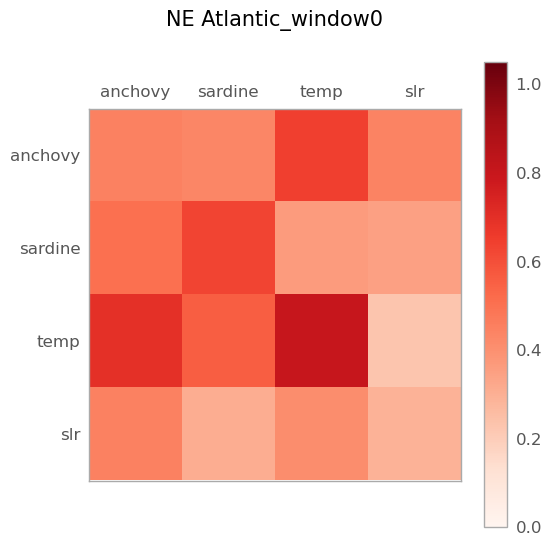


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 6
pc_alpha = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 4 link(s):
    [pc_alpha = 0.5]
        ($sea_level$ -6): max_pval = 0.08304, min_val =  0.828
        ($temp.mean$ -6): max_pval = 0.45956, min_val =  0.378
        ($temp.mean$ -1): max_pval = 0.49144, min_val = -0.411
        ($temp.mean$ -3): max_pval = 0.44986, min_val =  0.344

    Variable $S.landing$ has 3 link(s):
    [pc_alpha = 0.5]
        ($temp.mean$ -6): max_pval = 0.13698, min_val = -0.759
        ($temp.mean$ -1): max_pval = 0.48115, min_val = -0.420
        ($temp.mean$ -2): max_pval = 0.48583, min_val =  0.416

    Variable $temp.mean$ has 3 link(s):
    [pc_alpha = 0.5]
        ($S.landing$ -1): max_pval = 0.10522, min_val = -0.722
        ($temp.mean$ -6): max_pval = 0.41333, min_val =

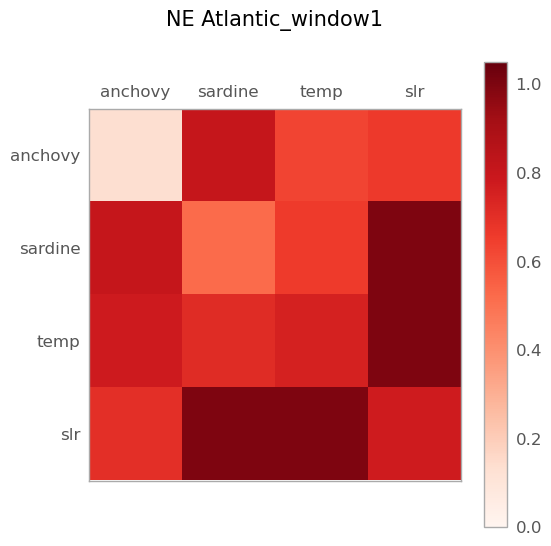


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 6
pc_alpha = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 4 link(s):
    [pc_alpha = 0.5]
        ($sea_level$ -4): max_pval = 0.16649, min_val = -0.586
        ($S.landing$ -2): max_pval = 0.30089, min_val =  0.584
        ($temp.mean$ -2): max_pval = 0.25796, min_val =  0.454
        ($S.landing$ -1): max_pval = 0.43667, min_val = -0.353

    Variable $S.landing$ has 4 link(s):
    [pc_alpha = 0.5]
        ($sea_level$ -3): max_pval = 0.06749, min_val =  0.721
        ($A.landing$ -1): max_pval = 0.16844, min_val = -0.584
        ($A.landing$ -4): max_pval = 0.24181, min_val =  0.510
        ($temp.mean$ -5): max_pval = 0.40738, min_val =  0.342

    Variable $temp.mean$ has 3 link(s):
    [pc_alpha = 0.5]
        ($A.landing$ -6): max_pval = 0.20781, min_val =

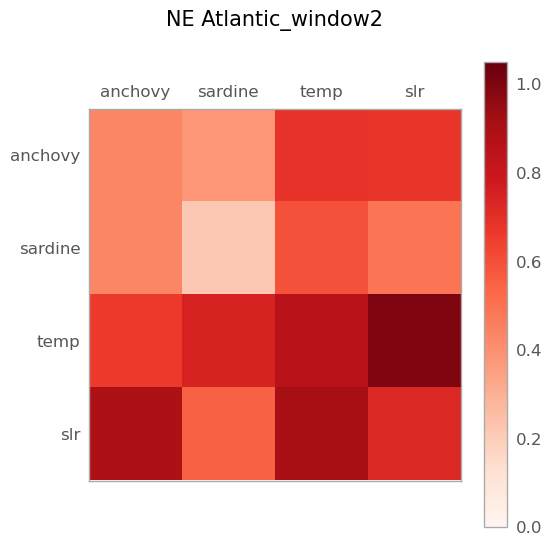


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 6
pc_alpha = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 3 link(s):
    [pc_alpha = 0.5]
        ($S.landing$ -3): max_pval = 0.21123, min_val =  0.597
        ($A.landing$ -2): max_pval = 0.33178, min_val = -0.433
        ($A.landing$ -5): max_pval = 0.43368, min_val = -0.356

    Variable $S.landing$ has 5 link(s):
    [pc_alpha = 0.5]
        ($sea_level$ -2): max_pval = 0.11922, min_val = -0.643
        ($A.landing$ -6): max_pval = 0.41355, min_val = -0.480
        ($sea_level$ -4): max_pval = 0.44540, min_val = -0.389
        ($A.landing$ -4): max_pval = 0.47781, min_val =  0.295
        ($A.landing$ -3): max_pval = 0.48375, min_val = -0.291

    Variable $temp.mean$ has 3 link(s):
    [pc_alpha = 0.5]
        ($temp.mean$ -4): max_pval = 0.13214, min_val =

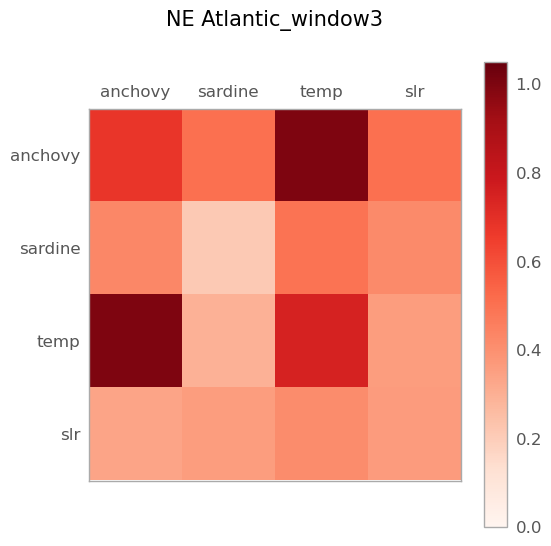


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 6
pc_alpha = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 3 link(s):
    [pc_alpha = 0.5]
        ($S.landing$ -4): max_pval = 0.37786, min_val = -0.397
        ($S.landing$ -6): max_pval = 0.49617, min_val = -0.407
        ($A.landing$ -1): max_pval = 0.45268, min_val =  0.384

    Variable $S.landing$ has 2 link(s):
    [pc_alpha = 0.3]
        ($temp.mean$ -4): max_pval = 0.10696, min_val =  0.660
        ($temp.mean$ -3): max_pval = 0.25371, min_val =  0.554

    Variable $temp.mean$ has 4 link(s):
    [pc_alpha = 0.4]
        ($temp.mean$ -4): max_pval = 0.15190, min_val = -0.848
        ($A.landing$ -5): max_pval = 0.26058, min_val =  0.624
        ($temp.mean$ -6): max_pval = 0.22186, min_val =  0.529
        ($A.landing$ -6): max_pval = 0.34311, min_val =

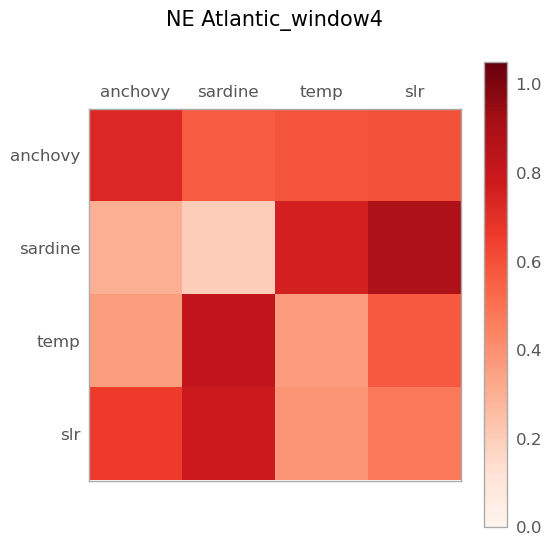


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 6
pc_alpha = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 3 link(s):
    [pc_alpha = 0.4]
        ($S.landing$ -4): max_pval = 0.32507, min_val = -0.438
        ($S.landing$ -6): max_pval = 0.33404, min_val =  0.431
        ($temp.mean$ -3): max_pval = 0.39012, min_val =  0.388

    Variable $S.landing$ has 5 link(s):
    [pc_alpha = 0.5]
        ($sea_level$ -5): max_pval = 0.10890, min_val = -0.794
        ($sea_level$ -1): max_pval = 0.41890, min_val =  0.475
        ($sea_level$ -2): max_pval = 0.39698, min_val = -0.428
        ($A.landing$ -3): max_pval = 0.34210, min_val = -0.388
        ($A.landing$ -5): max_pval = 0.49465, min_val = -0.351

    Variable $temp.mean$ has 1 link(s):
    [pc_alpha = 0.05]
        ($A.landing$ -3): max_pval = 0.04012, min_val 

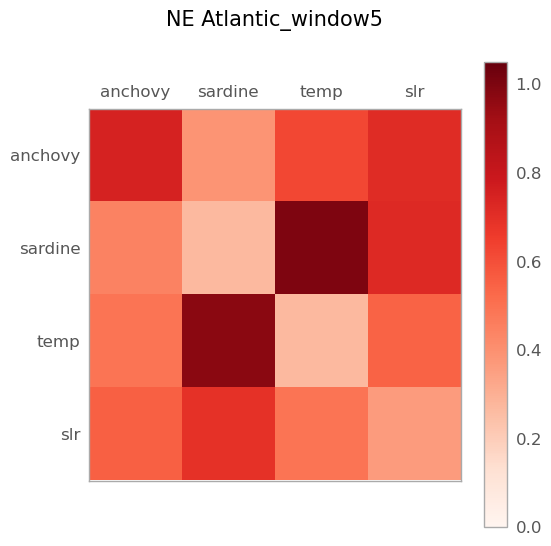


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 6
pc_alpha = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 5 link(s):
    [pc_alpha = 0.5]
        ($S.landing$ -5): max_pval = 0.45648, min_val =  0.544
        ($S.landing$ -2): max_pval = 0.31521, min_val =  0.498
        ($A.landing$ -3): max_pval = 0.31801, min_val =  0.406
        ($A.landing$ -1): max_pval = 0.37730, min_val = -0.397
        ($temp.mean$ -2): max_pval = 0.44195, min_val =  0.350

    Variable $S.landing$ has 3 link(s):
    [pc_alpha = 0.5]
        ($sea_level$ -3): max_pval = 0.30502, min_val = -0.455
        ($S.landing$ -2): max_pval = 0.37125, min_val = -0.449
        ($A.landing$ -5): max_pval = 0.44136, min_val = -0.319

    Variable $temp.mean$ has 4 link(s):
    [pc_alpha = 0.5]
        ($S.landing$ -6): max_pval = 0.39662, min_val =

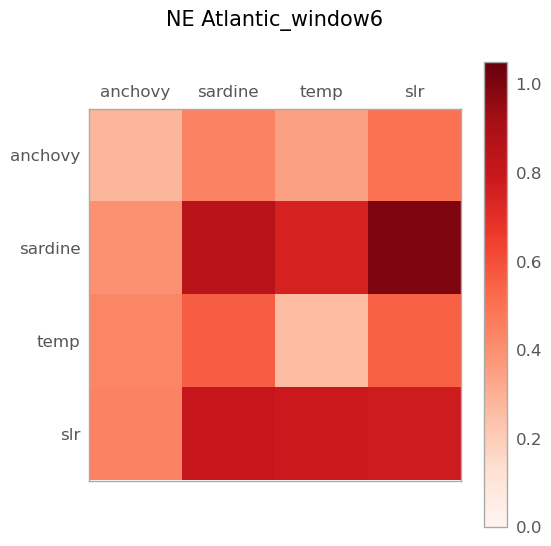


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 6
pc_alpha = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 5 link(s):
    [pc_alpha = 0.5]
        ($temp.mean$ -2): max_pval = 0.03878, min_val = -0.898
        ($temp.mean$ -1): max_pval = 0.25424, min_val = -0.554
        ($temp.mean$ -6): max_pval = 0.36227, min_val =  0.526
        ($A.landing$ -5): max_pval = 0.41921, min_val = -0.475
        ($sea_level$ -4): max_pval = 0.42362, min_val = -0.471

    Variable $S.landing$ has 3 link(s):
    [pc_alpha = 0.3]
        ($A.landing$ -1): max_pval = 0.15697, min_val = -0.597
        ($sea_level$ -5): max_pval = 0.20647, min_val =  0.544
        ($sea_level$ -3): max_pval = 0.20812, min_val =  0.543

    Variable $temp.mean$ has 3 link(s):
    [pc_alpha = 0.4]
        ($sea_level$ -6): max_pval = 0.05654, min_val =

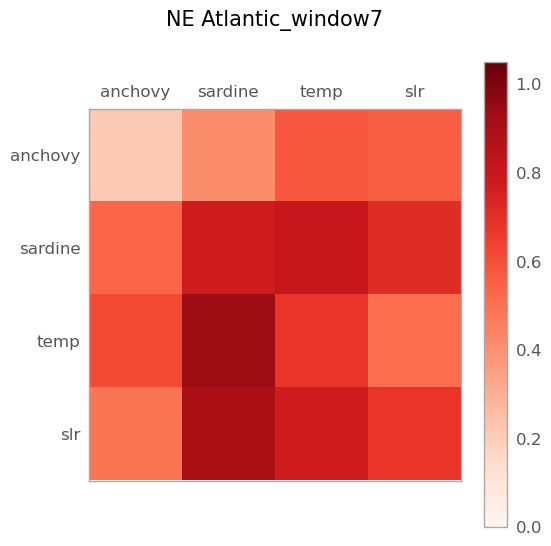

In [27]:
A = []
S = []
T = []
SLR = []
TA = []
TS = []
SLRA = []
SLRS = []

for i in range(0, number):
    matrix = Run_PCMCI(all_clips[i], 6)
    Plot_Matrix(matrix, 'NE Atlantic_window%s'%i)
    A.append(matrix[0][0])
    S.append(matrix[1][1])
    T.append(matrix[2][2])
    SLR.append(matrix[3][3])
    TA.append(matrix[2][0])
    TS.append(matrix[2][1])
    SLRA.append(matrix[3][0])
    SLRS.append(matrix[3][1])
    
import csv

content = zip(A, S, T, SLR, TA, TS, SLRA, SLRS)

with open('NE Atlantic_interactions.csv', "w") as s:
    w = csv.writer(s)
    for row in content:
        w.writerow(row)

In [11]:
A = []
S = []
ST = []
AT = []
SLR = []
TA = []
TS = []
SLRA = []
SLRS = []

for i in range(0, number):
    matrix = Run_PCMCI(all_clips[i], 7)
    A.append(matrix[0][0])
    S.append(matrix[1][1])
    ST.append(matrix[2][2])
    AT.append(matrix[3][3])
    SLR.append(matrix[4][4])
    TA.append(matrix[3][0])
    TS.append(matrix[2][1])
    SLRA.append(matrix[4][0])
    SLRS.append(matrix[4][1])
    
import csv

content = zip(A, S, ST, AT, SLR, TA, TS, SLRA, SLRS)

with open('SouthAmerica_interactions.csv', "w") as s:
    w = csv.writer(s)
    for row in content:
        w.writerow(row)

D:\Anaconda\Anaconda3\lib\site-packages\tigramite\data_processing.py:296: UserWarning: In analysis mode 'multiple'. There is just a single dataset, is this as intended?'
  warnings.warn("In analysis mode 'multiple'. There is just a "\



##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 7
pc_alpha = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 5 link(s):
    [pc_alpha = 0.5]
        ($anchovy_temp$ -3): max_pval = 0.15919, min_val =  0.733
        ($A.landing$ -3): max_pval = 0.34836, min_val =  0.469
        ($sardine_temp$ -1): max_pval = 0.38547, min_val = -0.438
        ($sardine_temp$ -6): max_pval = 0.47325, min_val =  0.427
        ($anchovy_temp$ -7): max_pval = 0.48729, min_val = -0.357

    Variable $S.landing$ has 6 link(s):
    [pc_alpha = 0.5]
        ($sea_level$ -5): max_pval = 0.17180, min_val = -0.718
        ($S.landing$ -4): max_pval = 0.06895, min_val =  0.931
        ($sardine_temp$ -1): max_pval = 0.40558, min_val =  0.594
        ($S.landing$ -1): max_pval = 0.02856, min_val =  0.999
        ($anchovy_temp$ -4): max_pval =


## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 2 link(s):
    [pc_alpha = 0.4]
        ($anchovy_temp$ -2): max_pval = 0.17593, min_val =  0.714
        ($A.landing$ -1): max_pval = 0.34764, min_val = -0.469

    Variable $S.landing$ has 3 link(s):
    [pc_alpha = 0.5]
        ($anchovy_temp$ -2): max_pval = 0.27644, min_val =  0.533
        ($sardine_temp$ -6): max_pval = 0.48854, min_val =  0.414
        ($sea_level$ -6): max_pval = 0.49388, min_val = -0.352

    Variable $sardine_temp$ has 2 link(s):
    [pc_alpha = 0.2]
        ($A.landing$ -3): max_pval = 0.19001, min_val = -0.698
        ($sea_level$ -3): max_pval = 0.12751, min_val = -0.692

    Variable $anchovy_temp$ has 3 link(s):
    [pc_alpha = 0.4]
        ($A.landing$ -7): max_pval = 0.33115, min_val = -0.669
        ($anchovy_temp$ -2): max_pval = 0.39275, min_val = -0.607
        ($anchovy_temp$ -6): max_pval = 0.30208, min_val = -0.583

    Variable $sea_level$ has 6 link(s):
    [pc_alpha = 0.5


## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 3 link(s):
    [pc_alpha = 0.4]
        ($anchovy_temp$ -3): max_pval = 0.32612, min_val =  0.872
        ($S.landing$ -7): max_pval = 0.37490, min_val = -0.832
        ($S.landing$ -4): max_pval = 0.30541, min_val = -0.580

    Variable $S.landing$ has 2 link(s):
    [pc_alpha = 0.4]
        ($anchovy_temp$ -1): max_pval = 0.38215, min_val =  0.618
        ($A.landing$ -1): max_pval = 0.35142, min_val = -0.536

    Variable $sardine_temp$ has 1 link(s):
    [pc_alpha = 0.2]
        ($sardine_temp$ -5): max_pval = 0.16211, min_val =  0.650

    Variable $anchovy_temp$ has 5 link(s):
    [pc_alpha = 0.5]
        ($anchovy_temp$ -6): max_pval = 0.43014, min_val =  0.780
        ($sardine_temp$ -7): max_pval = 0.27799, min_val = -0.906
        ($sea_level$ -6): max_pval = 0.35510, min_val = -0.848
        ($A.landing$ -6): max_pval = 0.32495, min_val =  0.489
        ($sea_level$ -7): max_pval = 0.41973, min_val =  0.4